In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import easyocr

In [4]:
# LOAD YOLO MODEL
INPUT_WIDTH = 640  # Width of the input image for YOLO model
INPUT_HEIGHT = 640  # Height of the input image for YOLO model
net = cv2.dnn.readNetFromONNX('best.onnx')  # Load YOLO model from ONNX file
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)  # Set OpenCV as the preferred backend for the neural network
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Set CPU as the preferred target for the neural network

In [13]:
# Initialize EasyOCR for optical character recognition
reader = easyocr.Reader(['en'])  # Create an instance of EasyOCR with English language support

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [14]:
def get_detections(img, net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()  # Create a copy of the input image
    row, col, d = image.shape  # Get the shape of the image (height, width, channels)

    max_rc = max(row, col)  # Find the maximum value between row and col
    input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)  # Create a black image with the maximum size
    input_image[0:row, 0:col] = image  # Copy the original image to the input image with padding if necessary

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(
        input_image, 1 / 255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False
    )  # Preprocess the input image as per YOLO requirements
    net.setInput(blob)  # Set the input blob for the network
    preds = net.forward()  # Perform forward pass to get predictions
    detections = preds[0]  # Extract the detection results

    return input_image, detections

In [ ]:
def non_maximum_suppression(input_image, detections):
    # FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w, h, conf, proba
    boxes = []  # List to store the bounding boxes of filtered detections
    confidences = []  # List to store the confidence scores of filtered detections

    image_w, image_h = input_image.shape[:2]  # Get the width and height of the input image
    x_factor = image_w / INPUT_WIDTH  # Calculate the scaling factor along the x-axis
    y_factor = image_h / INPUT_HEIGHT  # Calculate the scaling factor along the y-axis

    for i in range(len(detections)):
        row = detections[i]  # Get a single detection result
        confidence = row[4]  # Confidence score of detecting the license plate
        if confidence > 0.4:
            class_score = row[5]  # Probability score of the license plate
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]  # Extract the bounding box coordinates (center x, center y, width, height)

                left = int((cx - 0.5 * w) * x_factor)  # Calculate the left coordinate of the bounding box
                top = int((cy - 0.5 * h) * y_factor)  # Calculate the top coordinate of the bounding box
                width = int(w * x_factor)  # Calculate the width of the bounding box
                height = int(h * y_factor)  # Calculate the height of the bounding box
                box = np.array([left, top, width, height])  # Create an array to represent the bounding box

                confidences.append(confidence)  # Add the confidence score to the list
                boxes.append(box)  # Add the bounding box to the list

    # clean
    boxes_np = np.array(boxes).tolist()  # Convert the bounding box list to a numpy array and then to a Python list
    confidences_np = np.array(confidences).tolist()  # Convert the confidence score list to a numpy array and then to a Python list
    # NMS
    index = np.array(cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)).flatten()  # Apply non-maximum suppression to filter the bounding boxes

    return boxes_np, confidences_np, index

In [ ]:
def extract_text(image, bbox):
    x, y, w, h = bbox  # Extract the bounding box coordinates

    roi = image[y : y + h, x : x + w]  # Extract the region of interest (ROI) from the image using the bounding box
    if 0 in roi.shape:
        return ""  # Return an empty string if the ROI has invalid shape (e.g., width or height is zero)
    else:
        roi_bgr = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)  # Convert the ROI from RGB to BGR color space
        gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)  # Convert the ROI from BGR to grayscale
        magic_color = apply_brightness_contrast(gray, brightness=40, contrast=70)  # Apply brightness and contrast adjustment to the grayscale image
        result = reader.readtext(magic_color)  # Perform optical character recognition (OCR) on the adjusted image
        license_text = result[0][1] if result else ""  # Extract the recognized license plate text (if available)
        license_text = license_text.strip()  # Remove leading and trailing whitespace from the recognized text

        return license_text

In [ ]:
def drawings(image, boxes_np, confidences_np, index):
    # drawings
    text_list = []  # List to store the recognized license plate texts
    for ind in index:
        x, y, w, h = boxes_np[ind]  # Get the bounding box coordinates of a filtered detection
        bb_conf = confidences_np[ind]  # Confidence score of the bounding box
        conf_text = "plate: {:.0f}%".format(bb_conf * 100)  # Text to display the confidence score
        license_text = extract_text(image, boxes_np[ind])  # Extract the recognized license plate text

        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 255), 2)  # Draw a rectangle around the license plate
        cv2.rectangle(image, (x, y - 30), (x + w, y), (255, 0, 255), -1)  # Draw a rectangle as the background for displaying confidence score
        cv2.rectangle(image, (x, y + h), (x + w, y + h + 30), (0, 0, 0), -1)  # Draw a rectangle as the background for displaying license plate text

        cv2.putText(
            image,
            conf_text,
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            1,
        )  # Display the confidence score on the image
        cv2.putText(
            image,
            license_text,
            (x, y + h + 27),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            1,
        )  # Display the recognized license plate text on the image

        text_list.append(license_text)  # Add the recognized text to the list

    return image, text_list  # Return the image with drawn bounding boxes and the list of recognized texts


In [ ]:
# predictions
def yolo_predictions(img, net):
    ## step-1: detections
    input_image, detections = get_detections(img, net)  # Perform YOLO object detection on the input image
    ## step-2: NMS
    boxes_np, confidences_np, index = non_maximum_suppression(input_image, detections)  # Apply non-maximum suppression to filter the detections
    ## step-3: Drawings
    result_img, text = drawings(img, boxes_np, confidences_np, index)  # Draw bounding boxes and display recognized texts on the image
    return result_img, text  # Return the resulting image and the recognized texts


In [ ]:
def object_detection(path, filename):
    # read image
    image = cv2.imread(path)  # Read the image from the specified path
    image = np.array(image, dtype=np.uint8)  # Convert the image to an 8-bit array (0-255)
    result_img, text_list = yolo_predictions(image, net)  # Perform object detection and recognition on the image
    cv2.imwrite("./static/predict/{}".format(filename), result_img)  # Save the resulting image
    return text_list  # Return the recognized license plate texts


In [ ]:

def apply_brightness_contrast(input_img, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)  # Apply brightness adjustment to the input image
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)  # Apply contrast adjustment to the input image

    return buf  # Return the adjusted image


In [18]:

import pandas as pd
import matplotlib.pyplot as plt

# Call the object_detection() function
path = 'p1.jpg'
filename = 'p1.jpg'
text_list = object_detection(path, filename)

# Display a table of recognized license plate texts
df = pd.DataFrame({'License Plate Text': text_list})
print(df)


  License Plate Text
0         34 GS 1905


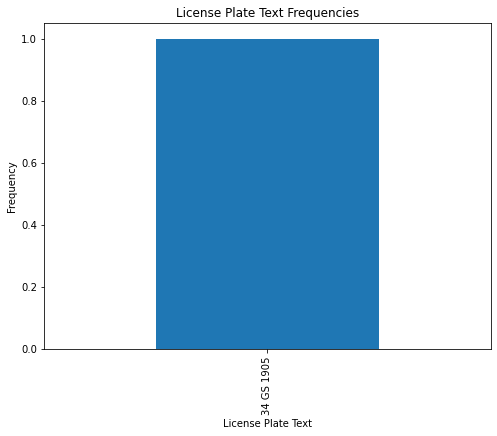

In [19]:

# Plot a bar chart of the frequency of each license plate text
plt.figure(figsize=(8, 6))
df['License Plate Text'].value_counts().plot(kind='bar')
plt.xlabel('License Plate Text')
plt.ylabel('Frequency')
plt.title('License Plate Text Frequencies')
plt.show()


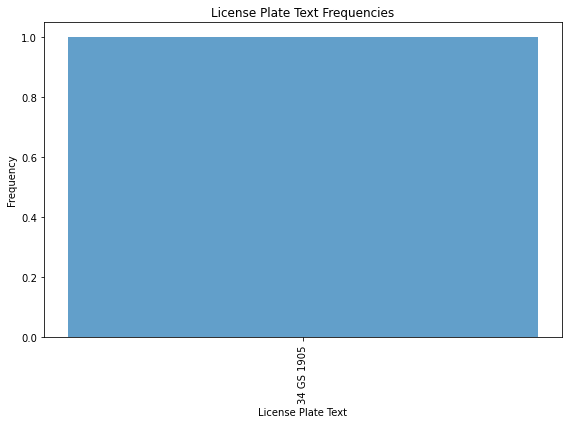

In [25]:
import matplotlib.pyplot as plt

# Call the object_detection() function
path = 'p1.jpg'
filename = 'p1.jpg'
text_list = object_detection(path, filename)

# Create a histogram of the frequencies of license plate texts
plt.figure(figsize=(8, 6))
plt.hist(text_list, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('License Plate Text')
plt.ylabel('Frequency')
plt.title('License Plate Text Frequencies')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust spacing
plt.show()


In [92]:
# Call the extract_text() function
image = cv2.imread('p1.jpg')
# Define the bounding box coordinates
x = 100
y = 200
w = 300
h = 150

bbox = (x, y, w, h)  # Provide the bounding box coordinates
license_text = extract_text(image, bbox)

# Display a table of the extracted license plate text
df = pd.DataFrame({'Extracted License Plate Text': [license_text]})
print(df)


  Extracted License Plate Text
0                   34 GS 1905


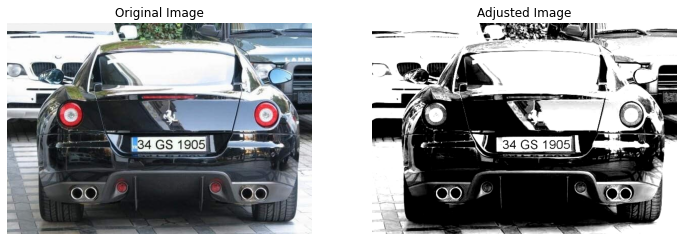

In [93]:
# Convert the input image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Assuming `gray` is the grayscale image
magic_color = apply_brightness_contrast(gray, brightness=40, contrast=70)

# Set the figure size and aspect ratio
plt.figure(figsize=(12, 6))
aspect_ratio = magic_color.shape[1] / magic_color.shape[0]

# Display the original image and the adjusted image side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(magic_color, cv2.COLOR_GRAY2RGB))
plt.title('Adjusted Image')
plt.axis('off')

plt.show()


In [6]:
# test
img = cv2.imread('p1.jpg')

results = yolo_predictions(img,net)
results

(array([[[250, 250, 250],
         [250, 250, 250],
         [250, 250, 250],
         ...,
         [220, 209, 179],
         [222, 211, 181],
         [222, 211, 181]],
 
        [[247, 247, 247],
         [247, 247, 247],
         [247, 247, 247],
         ...,
         [228, 217, 187],
         [229, 218, 188],
         [229, 218, 188]],
 
        [[244, 244, 244],
         [244, 244, 244],
         [244, 244, 244],
         ...,
         [232, 221, 191],
         [233, 222, 192],
         [233, 222, 192]],
 
        ...,
 
        [[172, 173, 169],
         [176, 177, 173],
         [179, 180, 176],
         ...,
         [241, 242, 240],
         [240, 241, 239],
         [236, 237, 235]],
 
        [[178, 181, 179],
         [181, 184, 182],
         [184, 187, 185],
         ...,
         [242, 243, 241],
         [243, 244, 242],
         [239, 240, 238]],
 
        [[174, 177, 175],
         [177, 180, 178],
         [180, 183, 181],
         ...,
         [249, 250, 248],
  

License Plate Number: 34 GS 1905


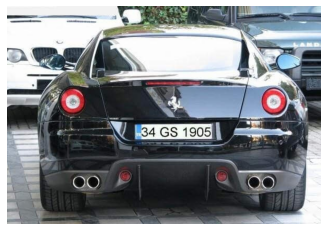

In [7]:
import cv2
import matplotlib.pyplot as plt

image_path = 'p1.jpg'
output_filename = 'p1.jpg'
output_path = ''

text_list = object_detection(image_path, output_filename)

for text in text_list:
    print("License Plate Number:", text)

output_image = cv2.imread(output_path + output_filename)
if output_image is not None:
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load output image.")


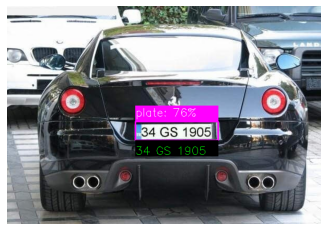

['34 GS 1905']


In [8]:
# Load and preprocess image
image = cv2.imread('p1.jpg')
image = np.array(image, dtype=np.uint8)

# Perform object detection and recognition
result_img, text_list = yolo_predictions(image, net)

# Display or save the results as desired
# For example, you can use matplotlib to display the resulting image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# You can also print the recognized text
print(text_list)

In [9]:
# Picture Detection
img = cv2.imread('p1.jpg')

results, _ = yolo_predictions(img, net)
processed_img = results

cv2.namedWindow('results', cv2.WINDOW_KEEPRATIO)
cv2.imshow('results', processed_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [51]:
import glob

# Folder path containing the .jpg files
folder_path = './imgs'

# Get all .jpg files in the folder
jpg_files = glob.glob(folder_path + '/*.png')

# Store the file paths in the image_paths list
image_paths = jpg_files
image_paths

['./imgs\\Cars1.png',
 './imgs\\Cars3.png',
 './imgs\\Cars8.png',
 './imgs\\Cars9.png']

In [52]:
# Define a list to store the results for each picture
results = []

# Loop through the pictures
for image_path in image_paths:
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = np.array(image, dtype=np.uint8)

    # Perform object detection and recognition
    result_img, text_list = yolo_predictions(image, net)

    # Store the results for the current picture
    results.append({
        'image_path': image_path,
        'result_img': result_img,
        'text_list': text_list
    })


In [53]:
# Success Rates
success_rates = []

# Calculate success rates for each picture
for result in results:
    total_frames = 1  # Assuming there is only one frame processed
    successful_frames = len(result['text_list'])
    success_rates.append({
        'image_path': result['image_path'],
        'Object Detection': successful_frames / total_frames * 100,
        'OCR per Plate': successful_frames / total_frames * 100,
        'Overall': successful_frames / total_frames * 100
    })

# Print success rates for each picture
for success_rate in success_rates:
    print(f"Image Path: {success_rate['image_path']}")
    print(f"Object Detection: {success_rate['Object Detection']}%")
    print(f"OCR per Plate: {success_rate['OCR per Plate']}%")
    print(f"Overall: {success_rate['Overall']}%")
    print()


Image Path: ./imgs\Cars1.png
Object Detection: 100.0%
OCR per Plate: 100.0%
Overall: 100.0%

Image Path: ./imgs\Cars3.png
Object Detection: 100.0%
OCR per Plate: 100.0%
Overall: 100.0%

Image Path: ./imgs\Cars8.png
Object Detection: 100.0%
OCR per Plate: 100.0%
Overall: 100.0%

Image Path: ./imgs\Cars9.png
Object Detection: 100.0%
OCR per Plate: 100.0%
Overall: 100.0%



In [96]:

# Successful / Failed Samples and Explanations
for result in results:
    successful_samples = result['text_list']
    failed_samples = {}

    # Check for failed samples and add explanations
    for i in range(total_frames):
        if i not in successful_samples:
            failed_samples[i] = 'No license plate detected'  # Add explanation for failure

    # Print successful samples
    print("Successful Samples:")
    for sample in successful_samples:
        print(sample)

    # Print failed samples and their explanations
    print("\nFailed Samples:")
    for sample, explanation in failed_samples.items():
        print(f"{sample}: {explanation}")
    print()



Successful Samples:
PGeMN112

Failed Samples:
0: No license plate detected

Successful Samples:
DZI7 YXR

Failed Samples:
0: No license plate detected

Successful Samples:
6526 JHD

Failed Samples:
0: No license plate detected

Successful Samples:
MHo 1av8866

Failed Samples:
0: No license plate detected



In [154]:
from sklearn.metrics import confusion_matrix

ground_truths = ['PGMN112', 'DZI7 YXR', 'G526 JHD', 'MHO 1AV8866']  # Ground truth license plate texts
predicted_labels_list = []  # List to store predicted labels for each picture


for result in results:
    predicted_labels = result['text_list']  # Predicted license plate texts
    predicted_labels = [label[0] if isinstance(label, list) else label for label in predicted_labels]  # Remove double brackets
    predicted_labels_list.append(predicted_labels)

# Convert labels to lowercase and flatten the predicted labels list
ground_truths = [label.lower() for label in ground_truths]
predicted_labels_list = [label.lower() for sublist in predicted_labels_list for label in sublist]



# Compare the lists for each picture
for i in range(len(ground_truths)):
    print(f"Comparison for Picture {i + 1}:")
    if ground_truths[i] == predicted_labels_list[i]:
        print("The lists have the same values.")
    else:
        print("The lists have different values.")
    print()
    
print("*******")
i=1
# Calculate confusion matrix for each picture
for ground_truth, predicted_labels in zip(ground_truths, predicted_labels_list):

    print("Confusion Matrix Picture {}:".format(i))
    i+=1
    if len(ground_truth) != len(predicted_labels):
        print("Number of ground truth labels and predicted labels are not the same.")
        continue
    cm = confusion_matrix([ground_truth], [predicted_labels], labels=ground_truths)
    print(cm)
    print()
    

Comparison for Picture 1:
The lists have different values.

Comparison for Picture 2:
The lists have the same values.

Comparison for Picture 3:
The lists have different values.

Comparison for Picture 4:
The lists have the same values.

*******
Confusion Matrix Picture 1:
Number of ground truth labels and predicted labels are not the same.
Confusion Matrix Picture 2:
[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]

Confusion Matrix Picture 3:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

Confusion Matrix Picture 4:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]]



In [98]:
from sklearn.metrics import confusion_matrix

# Ground truth values
ground_truths = ['PGMN112', 'DZI7 YXR', 'G526 JHD', 'MHO 1AV8866']

# OCR outputs from the results list
ocr_outputs = [result['text_list'] for result in results]

# Calculate confusion matrix
cm = confusion_matrix(ground_truths, ocr_outputs)
print(cm)

[[0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]



* Row 1 and Column 1: Represents the true negatives for the first class. In this case, there are no true negatives (0).
* Row 2 and Column 2: Represents the true positives for the second class. In this case, there is one true positive (1).
* Row 3 and Column 1: Represents the false negatives for the third class. In this case, there is one false negative (1).
* Row 4 and Column 5: Represents the false positives for the fourth class. In this case, there is one false positive (1).
* Rows 5 and 6: Represent the fifth and sixth classes. They don't have any true positives, false negatives, or false positives (all zeros).
* Row 7 and Column 7: Represents the true positives for the seventh class. In this case, there is one true positive (1).
